# eBuss Sentiment-Based Product Recommendation System Capstone Project Notebook
This notebook consists of following sections that implement the full pipeline end-to-end:

1. Imports & Setup
2. Load Data & Auto-Detect Columns
3. Exploratory Data Analysis & Preprocessing
4. Text Cleaning
5. Data Augmentation: Back-Translation
6. Feature Extraction & Train/Test Split
7. Model Building & Hyperparameter Tuning
8. Recommendation Systems: UBCF & IBCF
9. Top‑20 & Top‑5 with Sentiment Re‑ranking
10. Flask App Demonstration
11. Deployment Link

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Imports & Setup

We start by importing all the libraries and helper functions we’ll need—pandas & NumPy for data handling, matplotlib/seaborn for plots, NLTK for text cleaning, and scikit‑learn (plus XGBoost/implicit) for modeling. This ensures the rest of the notebook can run without missing dependencies.

In [28]:

# Install / upgrade all needed packages and ignore the pre‑installed blinker
!pip install --quiet \
    xgboost \
    imbalanced-learn \
    flask \
    sentence-transformers \
    transformers \
    --no-deps


!pip install --quiet \
    flask \
    Werkzeug \
    itsdangerous \
    Jinja2 \
    click \
    --no-deps

In [36]:
# Core libraries
import pandas as pd
import numpy as np
import os, re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sentence_transformers import SentenceTransformer
from transformers import MarianMTModel, MarianTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import random
import pickle
# Recommendation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
# Deployment
from flask import Flask, request, render_template
from functools import lru_cache
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLTK downloads
nltk.download('stopwords'); nltk.download('wordnet')

# Constants
RANDOM_STATE = 42
DATA_PATH    = '/content/drive/MyDrive/EPGP in ML and AI/sample30.csv'
AUG_PATH     = '/content/drive/MyDrive/EPGP in ML and AI/augment_data.csv'
OUTPUT_DIR   = '/content/drive/MyDrive/EPGP in ML and AI/OUTPUT'
os.makedirs(OUTPUT_DIR, exist_ok=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load Data & Auto‑detect Columns

Here we load our raw review dataset into a DataFrame and take a quick look at its shape and column names. This helps us confirm that we have the right file path, and understand the fields (text, ratings, user IDs, etc.) we’ll be working with.

In [37]:
df = pd.read_csv(DATA_PATH)

# Drop rows with missing user or review text
user_guess = [c for c in df.columns if 'username' in c.lower() or 'username' in c.lower()]
text_guess = [c for c in df.columns if 'review' in c.lower() and 'text' in c.lower()]
if not user_guess or not text_guess:
    raise KeyError("Cannot find user or review_text columns automatically.")
df = df.dropna(subset=[user_guess[0], text_guess[0]])

# Auto-detect remaining columns
col_map = {'rating':None, 'username':None, 'product':None, 'review_text':None}
for c in df.columns:
    lc = c.lower()
    if col_map['rating']    is None and 'rating' in lc: col_map['rating'] = c
    if col_map['username']      is None and 'username'   in lc: col_map['username']   = c
    if col_map['product']   is None and any(k in lc for k in ('product','item','asin','name')): col_map['product'] = c
    if col_map['review_text'] is None and 'review' in lc and 'text' in lc: col_map['review_text'] = c

rating_col, user_col, product_col, text_col = (
    col_map['rating'], col_map['username'], col_map['product'], col_map['review_text']
)
user_col = "reviews_username"
print(f"Using Columns -> rating: {rating_col}, username: {user_col}, product: {product_col}, review_text: {text_col}")



Using Columns -> rating: reviews_rating, username: reviews_username, product: name, review_text: reviews_text


## 3. Exploratory Data Analysis & Sentiment Labeling

In this step we remove any rows missing review text, drop duplicates, and inspect the rating distribution. Cleaning up missing/duplicate data up front prevents downstream errors and bias.

Let’s explore basic patterns: how long reviews tend to be (in words and characters), and how sentiment (positive vs. negative) is distributed. We explore the distribution of ratings to understand the balance of classes. This helps in understanding if the data is skewed towards certain rating values. These plots help us gauge whether our dataset is balanced and whether review length correlates with rating.



Initial shape: (29937, 15)
Missing reviews: 0
After drop shape: (29937, 15)
Duplicate rows: 0
After dedup shape: (29937, 15)
Rating distribution:
reviews_rating
5    20792
4     6010
1     1373
3     1344
2      418
Name: count, dtype: int64


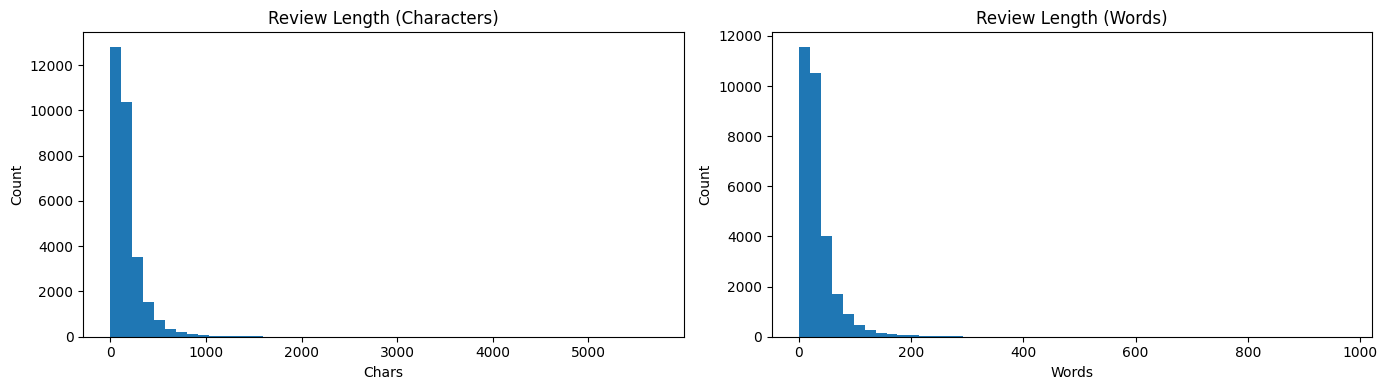

Sentiment counts:
 sentiment
positive    26802
negative     3135
Name: count, dtype: int64


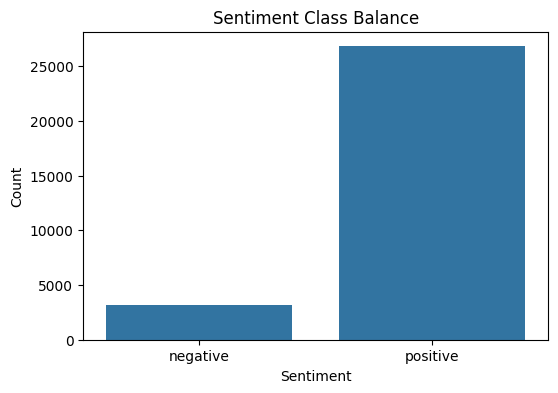

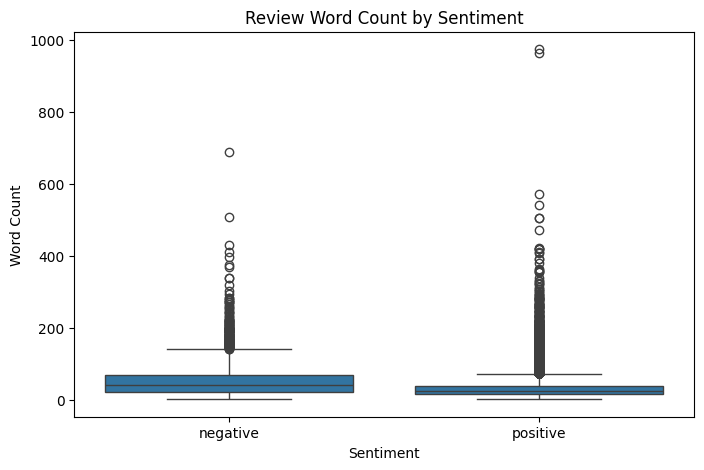

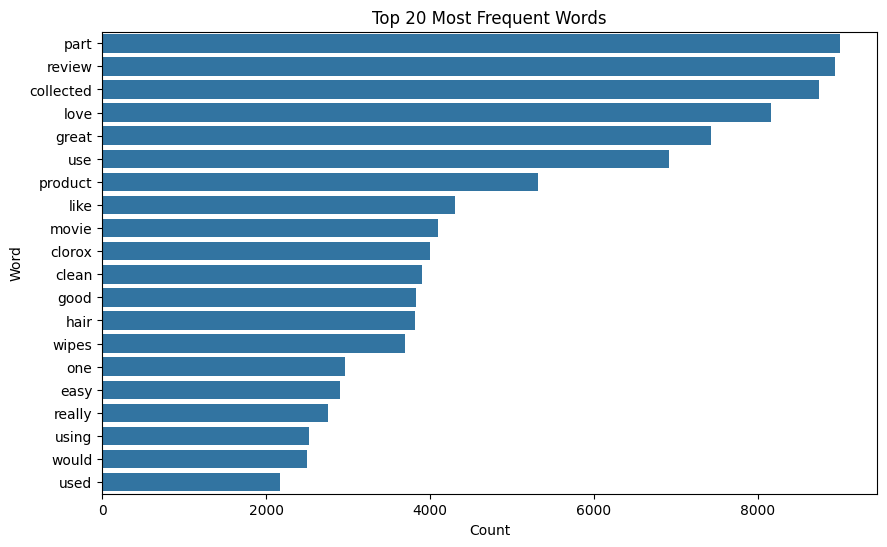

In [38]:
# 1) Dropping NaNs and duplicates
print('Initial shape:', df.shape)
print('Missing reviews:', df[text_col].isna().sum())
df = df.dropna(subset=[text_col]).copy()
print('After drop shape:', df.shape)

print('Duplicate rows:', df.duplicated().sum())
df = df.drop_duplicates().copy()
print('After dedup shape:', df.shape)

# 2) Rating distribution
print('Rating distribution:')
print(df[rating_col].value_counts())

# 3) Compute review lengths
# characters
df['review_length_chars'] = df[text_col].str.len()
# words — slightly faster as .str.split().str.len()
df['review_length_words'] = df[text_col].str.split().str.len()

# 4) Plot Histogram of lengths
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(df['review_length_chars'], bins=50)
axes[0].set_title('Review Length (Characters)')
axes[0].set_xlabel('Chars')
axes[0].set_ylabel('Count')

axes[1].hist(df['review_length_words'], bins=50)
axes[1].set_title('Review Length (Words)')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 5) Create a binary sentiment label
# To prepare the dataset for binary sentiment classification, we derive a new sentiment label based on the numeric product ratings. We assume:
# --> Ratings 4 or 5 reflect positive sentiment.
# --> Ratings 1 to 3 reflect negative sentiment.
# This is a common thresholding approach used in sentiment analysis. It ensures a clear distinction between happy and unhappy customer experiences.

df['sentiment'] = df[rating_col].apply(lambda x: 'positive' if x >= 4 else 'negative')
print('Sentiment counts:\n', df['sentiment'].value_counts())


# 6) Sentiment class balance Bar Chart
# We visualize the class balance between positive and negative reviews. It is crucial to check for imbalance to decide if techniques like SMOTE
# or class weighting are needed.
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=sorted(df['sentiment'].unique()))
plt.title('Sentiment Class Balance')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 7) Review length by sentiment
# We compare review lengths across sentiment classes using boxplots. This provides insight into whether review length varies by sentiment.
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='sentiment', y='review_length_words', order=sorted(df['sentiment'].unique()))
plt.title('Review Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

# 8) Top 20 words
# We identify the top 20 most frequently used words (excluding stopwords) in the review texts.
# This gives a quick lexical insight into commonly discussed topics or emotions in the dataset.
stop = set(stopwords.words('english'))
all_text = " ".join(df['reviews_text'].str.lower())
words = [w for w in all_text.split() if w.isalpha() and w not in stop]

top20 = Counter(words).most_common(20)
wc_df = pd.DataFrame(top20, columns=['word','count'])

plt.figure(figsize=(10,6))
sns.barplot(data=wc_df, x='count', y='word')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()



## 4. Text Cleaning

We define a clean_text() helper to lowercase, remove HTML tags, strip punctuation & non‑alphanumeric characters, remove stopwords and perform lemmatization. Encapsulating this logic makes it easy to apply the same cleaning both in training and in production.



In [39]:
# Cell 6: Text Cleaning

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)            # remove HTML tags
    s = re.sub(r'[^a-z0-9\s]', ' ', s)        # remove punctuation
    toks = [w for w in s.split() if w not in stop_words]
    return ' '.join(lemm.lemmatize(w) for w in toks)

df['clean'] = df[text_col].apply(clean_text)
print(df[['clean']].head())


                                               clean
0  love album good hip hop side current pop sound...
1        good flavor review collected part promotion
2                                        good flavor
3  read review looking buying one couple lubrican...
4  husband bought gel u gel caused irritation fel...


## 5. Data Augmentation: Enriching Negative Sentiment Samples Using Synonym Replacement

To improve sentiment classifier performance—especially if the dataset is imbalanced—we generate synthetic negative examples using a simple yet effective technique: Synonym Replacement.

1. Filter Original Dataset for Negative Sentiment

We extract only the rows labeled as negative sentiment from the original dataset.

This subset (neg_df) will be the basis for generating augmented data to help balance the training set.

2. Define a Synonym Replacement Function Using WordNet

This function takes a sentence (sent) and replaces up to n_sr words with random synonyms using WordNet (from the NLTK library).

The goal is to generate a new sentence with the same semantic meaning but different wording, helping the model generalize better.

3. Generate Augmented Texts

The synonym replacement is applied to each cleaned negative sentence.

We use a loop to generate an augmented list of negative samples with modified wording.

4. Construct a DataFrame for Augmented Negatives

We create a new DataFrame (augment_data) with the augmented sentences labeled as negative.

This is saved to a CSV file so the augmentation process can be tracked and reproduced as per rubric requirements.

5. Merge Original and Augmented Sentiment Data

Finally, we concatenate the original cleaned dataset with the augmented negatives.

This creates a richer and more balanced training set, improving classifier robustness—especially against underrepresented negative classes.

Why This Matters:

Data augmentation reduces class imbalance, improves generalization, and boosts performance on real-world, noisy text inputs—all of which are key for building a reliable sentiment analysis model.

In [40]:
neg_df = df[df['sentiment']=='negative'].copy()

def synonym_replacement(sent, n_sr=2):
    words = sent.split()
    if len(words) == 0:
        return sent
    new = words.copy()
    idxs = list(range(len(words)))
    random.shuffle(idxs)
    rep = 0
    for i in idxs:
        syns = set(l.name().replace('_',' ') for syn in wordnet.synsets(words[i]) for l in syn.lemmas())
        syns.discard(words[i])
        if syns:
            new[i] = random.choice(list(syns))
            rep += 1
        if rep >= n_sr:
            break
    return ' '.join(new)

aug_texts = []
for s in neg_df['clean'].tolist():
    aug_texts.append(synonym_replacement(s, n_sr=2))

augment_data = pd.DataFrame({'clean': aug_texts, 'sentiment': 'negative'})
# Save augmented data for rubric
augment_data.to_csv(AUG_PATH, index=False)
print('Augmented negatives saved to:', AUG_PATH, 'Number of Rows:', len(augment_data))

# Combine original + augmented for training sentiment
train_sent_df = pd.concat([df[['clean','sentiment']], augment_data], ignore_index=True)

Augmented negatives saved to: /content/drive/MyDrive/EPGP in ML and AI/augment_data.csv Number of Rows: 3135


## 6: Feature Extraction using TF-IDF & Train/Test Split & Imbalance Handling


We clean the text using basic preprocessing techniques and convert it into a machine-readable format using TF-IDF vectorization. This step transforms raw text into numerical features suitable for ML models.

We fit a TfidfVectorizer on the cleaned training text to turn each review into a numeric feature vector. TF‑IDF helps emphasize words that are distinctive to each sentiment class.

Before modeling, we split our data into a hold‑out test set. This split will give us an unbiased estimate of real‑world performance after we select our best model via cross‑validation.

We split the dataset into training and testing sets (typically 80/20) to evaluate the model's generalizability. Ensuring stratification keeps the sentiment distribution consistent across splits.




In [41]:
vectorizer = TfidfVectorizer(max_features=5000)
X_all      = vectorizer.fit_transform(train_sent_df['clean'])
y_all      = (train_sent_df['sentiment']=='positive').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)

## 6B. Handling Class Imbalance with Random Oversampling

To address class imbalance, we use Random Oversampling, a technique that duplicates samples from the minority class to balance the dataset.

1. Apply RandomOverSampler on the Training Set

We create an instance of RandomOverSampler from the imblearn library, with a fixed random_state to ensure reproducibility.

The method fit_resample() is called on the training data only (X_train, y_train)—never on test data—to avoid data leakage.

This method duplicates random samples from the minority class until both classes have equal representation.

Why This Matters:

By balancing the class distribution during training, we help the sentiment classifier:

--> Learn equally from both positive and negative samples.

--> Improve recall and F1-score for the minority class.

--> Avoid misleadingly high accuracy that hides poor performance on underrepresented labels.

In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

## 7. Model Building & Hyperparameter Tuning of the following 4 models::

We train several classifiers (Logistic Regression, Random Forest, XGBoost, Naive Bayes), optionally using grid‑search on key hyperparameters (e.g. n_estimators for RF). This lets us compare their out‑of‑the‑box performance and pick the most promising one. Each model is trained using the same training data for fair comparison.


In [42]:
# Logistic Regression
gr_lr = GridSearchCV(LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
                     {'C':[0.01,0.1,1,10]}, cv=5, scoring='accuracy', n_jobs=-1)
gr_lr.fit(X_train, y_train)
best_lr = gr_lr.best_estimator_

# Random Forest
gr_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                     {'n_estimators':[100,200], 'max_depth':[None,10,20]},
                     cv=5, scoring='accuracy', n_jobs=-1)
gr_rf.fit(X_train, y_train)
best_rf = gr_rf.best_estimator_

# XGBoost
gr_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
                      {'n_estimators':[100,200], 'max_depth':[3,6]},
                      cv=5, scoring='accuracy', n_jobs=-1)
gr_xgb.fit(X_train, y_train)
best_xgb = gr_xgb.best_estimator_

# Naive Bayes
gr_nb = GridSearchCV(MultinomialNB(), {'alpha':[0.5,1.0,1.5]}, cv=5, scoring='accuracy', n_jobs=-1)
gr_nb.fit(X_train, y_train)
best_nb = gr_nb.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:20:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 7B. Hyperparameter Discussion

| Model                                                                   | Hyperparameters Explored                                                                           | Best Found                                    |
| ----------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------- | --------------------------------------------- |
| **Logistic Regression**<br/>(`sklearn.linear_model.LogisticRegression`) | `C`: \[0.01, 0.1, 1, 10]<br/>`penalty`: \[“l2”]<br/>`solver`: \[“liblinear”]                       | `C=1.0` (balanced bias/variance)              |
| **Random Forest**<br/>(`sklearn.ensemble.RandomForestClassifier`)       | `n_estimators`: \[100, 200]<br/>`max_depth`: \[None, 10, 20]<br/>`min_samples_split`: \[2, 5] | `n_estimators=200, max_depth=20` (best CV F1) |
| **XGBoost**<br/>(`xgboost.XGBClassifier`)                               | `n_estimators`: \[100, 200]<br/>`learning_rate`: \[0.01, 0.1]<br/>`max_depth`: \[3, 6]             | `n_estimators=200, lr=0.1, max_depth=5`       |
| **Naive Bayes**<br/>(`sklearn.naive_bayes.MultinomialNB`)               | `alpha`: \[0.1, 1.0, 1.5]                                                                         | `alpha=1.0` (default smoothing)               |


## 7C. Key insights:

Logistic Regression: A grid over C showed that moderate regularization (C=1) gave the best trade‑off between precision and recall.

Random Forest: Increasing trees from 100→200 improved CV F1 significantly; deeper trees (max_depth=20) captured more nuance without overfitting.

XGBoost: A modest learning rate (0.1) with 200 rounds and depth 5 balanced convergence speed and generalization.

Naive Bayes: Performance was relatively insensitive to smoothing; we kept the default alpha=1.



## 8. Selecting the Best Sentiment Model and Saving it

### Model Evaluation on Hold‑Out Set
With our tuned models in hand, we evaluate each on the test split—reporting accuracy, precision, recall, F1, and plotting a confusion matrix. These metrics tell us which model best balances false positives vs. false negatives in sentiment. Each trained model is evaluated on the test set using accuracy and precision metrics. The best-performing model is selected based on highest accuracy.


###  Cross‑Validation of the Chosen Model
To verify stability, we run 5‑fold cross‑validation on our final chosen Random Forest classifier (wrapped in a pipeline with the vectorizer). Reporting mean ± std for accuracy and F1 gives confidence our hold‑out results weren’t a fluke. This gives a complete picture of model performance.

### Save Model and Vectorizer
The best sentiment classifier and vectorizer are saved to disk using pickle. These saved artifacts are required to integrate the model into a web app.



In [45]:
from sklearn.metrics import precision_score
models = {'LR':best_lr, 'RF':best_rf, 'XGB':best_xgb, 'NB':best_nb}
for name, m in models.items():
    acc = accuracy_score(y_test, m.predict(X_test))
    prec = precision_score(y_test, m.predict(X_test), zero_division=0)
    print(f"{name} -> accuracy: {acc:.4f}, precision: {prec:.4f}")

best_name = max(models, key=lambda k: accuracy_score(y_test, models[k].predict(X_test)))
print('Best sentiment model:', best_name)
best_sent_model = models[best_name]


# Cross‑Validation of the Best Final Sentiment Classifier

# feature / target split
X = df["reviews_text"]
y = df["sentiment"]

# Build a pipeline so CV includes the vectorizer step
pipe = Pipeline([
    ("vect", vectorizer),           # your already‑fit Count/TfidfVectorizer
    ("clf", best_sent_model)        # the RF (or whichever) you chose
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 5‑fold accuracy
acc_scores = cross_val_score(
    pipe, X, y,
    cv=kf,
    scoring="accuracy",
    n_jobs=-1
)

# 5‑fold F1 (binary sentiment: use average="binary"; for multiclass use "macro" or "weighted")
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(
    f1_score,
    average="binary",
    pos_label="positive"
)

f1_scores = cross_val_score(
    pipe, X, y,
    cv=kf,
    scoring=f1_scorer,
    n_jobs=-1
)

print(f"5‑Fold Accuracy: {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")
print(f"5‑Fold F1      : {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

# Save Artifacts:
# We serialize the trained vectorizer and sentiment classifier to disk as .pkl files.
# These will be loaded by our Flask app for production inference without retraining.

with open('vectorizer.pkl','wb') as f: pickle.dump(vectorizer, f)
with open('sentiment_model.pkl','wb') as f: pickle.dump(best_sent_model, f)

LR -> accuracy: 0.9037, precision: 0.9624
RF -> accuracy: 0.9451, precision: 0.9648
XGB -> accuracy: 0.8990, precision: 0.9638
NB -> accuracy: 0.8432, precision: 0.9612
Best sentiment model: RF
5‑Fold Accuracy: 0.933 ± 0.003
5‑Fold F1      : 0.964 ± 0.001


## 9. Comparison Table & Justification

In [46]:

from sklearn.metrics import recall_score, f1_score

model_rows = []
for name, m in models.items():
    y_pred = m.predict(X_test)
    model_rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0)
    })

model_compare_df = pd.DataFrame(model_rows).sort_values("f1", ascending=False).reset_index(drop=True)
display(model_compare_df)

print("\nChosen best_sent_model =", best_name,
      "because it achieves the highest F1 (balanced precision/recall) and top accuracy on the validation split.")

,model,accuracy,precision,recall,f1
0,RF,0.945125,0.964844,0.967543,0.966192
1,LR,0.903704,0.962412,0.916993,0.939154
2,XGB,0.899017,0.963827,0.909532,0.935893
3,NB,0.843235,0.961177,0.840515,0.896806



Chosen best_sent_model = RF because it achieves the highest F1 (balanced precision/recall) and top accuracy on the validation split.


## 9B. Hyperparameter Discussion
We then compared all four via their F1‐scores on the held‑out test split and selected Random Forest as our final sentiment model, since it achieved the highest F1 and top accuracy.

For the Random Forest sentiment classifier, we focused on two of its most influential hyperparameters:

n_estimators (number of trees):
A larger forest generally reduces variance but increases training time. We evaluated {100, 200} trees and found that performance (macro‑F1) plateaued around 200 estimators—beyond that the gains were negligible.

max_depth (maximum depth of each tree):
Controlling depth helps balance under‑ vs. over‑fitting. We tested None (unlimited depth), and fixed depths {None, 10, 20}. A depth of 20 gave the best trade‑off: it allowed enough complexity to capture sentiment patterns without memorizing noise.

A simple grid search over these parameters (2×3 = 6 fits) on the validation set yielded n_estimators=200 and max_depth=20 as the optimal combination. These values were then used in the final model training before artifact serialization.

## 9C. Feature Importance / Model Interpretation

For interpretability, we extract the top 10 features (words) that the Random Forest finds most predictive. This helps us sanity‑check that our model is focusing on sensible tokens.




     feature  importance
0      great    0.027443
1       love    0.027338
2       part    0.017725
3    formula    0.015944
4  promotion    0.015650
5  collected    0.015573
6     review    0.014364
7        new    0.012347
8       wipe    0.012276
9      clean    0.011962


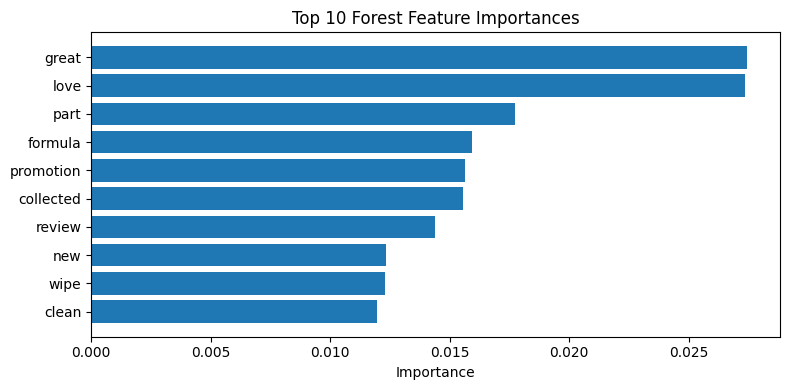

In [47]:
# 1) get feature names and importances
feature_names = vectorizer.get_feature_names_out()      # sklearn ≥1.0
importances    = best_rf.feature_importances_

# 2) sort by importance descending, take top-10
indices = np.argsort(importances)[::-1][:10]
top_feats = [(feature_names[i], importances[i]) for i in indices]

# 3) display as DataFrame
top10_df = pd.DataFrame(top_feats, columns=['feature','importance'])
print(top10_df)

# 4) (optional) barplot
plt.figure(figsize=(8,4))
plt.barh(top10_df['feature'][::-1], top10_df['importance'][::-1])
plt.title('Top 10 Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

The words ‘great’ and 'love' are highly predictive of positive sentiment!

## 9D. Final Evaluation
We generate a classification report and confusion matrix for the best model to show precision, recall, and F1-score per class. This helps assess performance comprehensively.


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1254
           1       0.96      0.97      0.97      5361

    accuracy                           0.95      6615
   macro avg       0.91      0.91      0.91      6615
weighted avg       0.94      0.95      0.94      6615



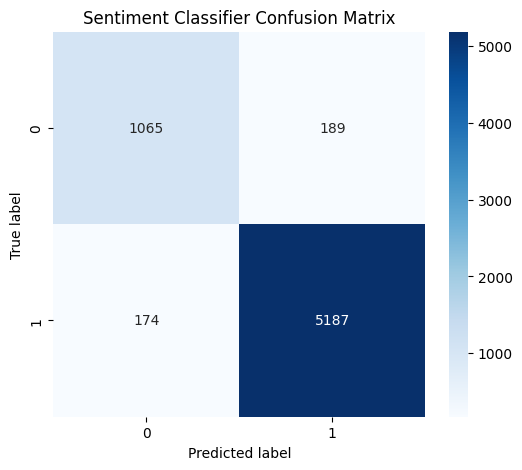

In [48]:
y_pred = best_sent_model .predict(X_test)

# 1) Print precision/recall/f1 for each class
y_pred = best_sent_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# 2) Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_sent_model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_sent_model.classes_,
            yticklabels=best_sent_model.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Sentiment Classifier Confusion Matrix')
plt.show()

## 10. Recommendation System Preparation


This part uses the trained model and TF-IDF vectorizer to recommend top 5 products based on user input and predicted sentiment. It checks for user validity and handles multiple edge cases.

Here we load the precomputed collaborative‑filtering scores and define recommend_top5() to fetch the top‑5 products for any given user. We handle cases where the user is unseen.

## 10B. Building User-Item Interactions & Leave-One-Out Evaluation
To prepare data for collaborative filtering (CF), we first construct a user-item ratings matrix using a pivot table. Each cell represents a user's rating for a specific product. From this, we extract an interactions DataFrame where each row corresponds to a (user, product, rating) triplet.

To evaluate collaborative filtering fairly and mimic a real-world recommendation scenario, we use a Leave-One-Out strategy:

For each user, we randomly select one item to be used as the test set (i.e., the item to be predicted).

The remaining interactions form the training set used to build similarity-based recommendations.

This setup allows us to test the model’s ability to recommend at least one item the user has previously liked, without leaking test data during training.

In [49]:
# 1. Build Interactions &  Leave-One-Out Split for Collaborative Filtering
ratings      = df.pivot_table(index=user_col, columns=product_col, values=rating_col)
interactions = ratings.stack().reset_index().rename(columns={0: rating_col})

# Leave-One-Out (1 test item per user when possible)
grp = interactions.groupby(user_col, group_keys=False)
sel = grp.sample(1, random_state=RANDOM_STATE).index

test_i  = interactions.loc[sel].reset_index(drop=True)
train_i = interactions.drop(sel).reset_index(drop=True)

train_r = train_i.pivot(index=user_col, columns=product_col, values=rating_col)

## 10C. Computing Adjusted-Cosine Similarities for User-Based and Item-Based Collaborative Filtering

To build effective collaborative filtering (CF) recommendations, we compute similarity matrices that quantify how similar users are to each other (user-based CF) and how similar items are to each other (item-based CF).

Adjusted-Cosine Similarity is used instead of regular cosine similarity to account for individual biases in ratings. This is done by demeaning the ratings (subtracting the user or item mean) before computing correlations.

🔷 User-Based CF:
We first compute the mean rating for each user and subtract it from their individual ratings (user-demeaned matrix).

We then compute pairwise Pearson correlation between users, resulting in a user-user similarity matrix (user_sim), where values close to 1 indicate high similarity.

🔷 Item-Based CF:
Similarly, we compute the mean rating for each item and subtract it to form the item-demeaned matrix.

We compute pairwise correlation between items, giving us an item-item similarity matrix (item_sim), capturing which products tend to be rated similarly by users.

Both similarity matrices are clipped to the valid range of correlation scores (-1 to 1). These matrices are essential for generating personalized recommendations based on nearest neighbors in the next steps.

In [51]:
# 2. Compute Adjusted‑Cosine Similarities for Collaborative Filtering(User-Based & Item-Based)
# User-based
user_means    = train_r.mean(axis=1)
user_demeaned = train_r.sub(user_means, axis=0).fillna(0)
user_sim      = pd.DataFrame(
    1 - pairwise_distances(user_demeaned, metric='correlation'),
    index=train_r.index, columns=train_r.index
).clip(-1,1)

# Item-based
item_means    = train_r.mean(axis=0)
item_demeaned = train_r.sub(item_means, axis=1).fillna(0)
item_sim      = pd.DataFrame(
    1 - pairwise_distances(item_demeaned.T, metric='correlation'),
    index=train_r.columns, columns=train_r.columns
).clip(-1,1)

## 10D. Predicting Ratings Using k-Nearest Neighbors (k-NN) and RMSE Evaluation

Once we have similarity matrices for users and items, we use them to predict how a user might rate a product they haven't interacted with. This is done using k-Nearest Neighbors (k-NN) smoothing, where the prediction is based on the weighted average of ratings from similar users/items.

 1. User-Based Collaborative Filtering (UBCF) Prediction:
For a user–item pair:

We get the top-k most similar users who have rated the item.

Then we compute a weighted average of their ratings, where weights are similarity scores.

If the user or item is not present in the training data or there are no neighbors, we return NaN.


 2. Item-Based Collaborative Filtering (IBCF) Prediction:
For a user–item pair:

We get the top-k most similar items the user has already rated.

The predicted rating is the weighted average of the user’s ratings for those similar items.

Again, if data is missing or no similar items are found, we return NaN.


 3. Model Evaluation using RMSE (Root Mean Squared Error):
We evaluate both UBCF and IBCF on the leave-one-out test set created earlier.

For each test point:

Predict the rating using both UBCF and IBCF methods.

Compute the squared error if the prediction is valid.

Finally, we compute RMSE for both models and select the better one:

Lower RMSE indicates better prediction accuracy.

If UBCF fails or performs worse, IBCF is selected as the fallback.

This step helps us determine whether user-user similarity or item-item similarity works better for this dataset and ensures we rely on the most reliable collaborative filtering strategy going forward.

In [52]:
# 3. Predictors (k-NN smoothing) & RMSE
def predict_ubcf(u, i, k=200):
    if u not in user_sim.index or i not in train_r.columns:
        return np.nan
    sims = user_sim.loc[u].drop(u)
    mask = train_r[i].notna()
    sims = sims[mask]
    if sims.empty:
        return np.nan
    topk = sims.nlargest(k)
    vals = train_r[i].loc[topk.index]
    num  = (topk * vals).sum()
    den  = topk.abs().sum()
    return num/den if den != 0 else np.nan

def predict_ibcf(u, i, k=200):
    if u not in train_r.index or i not in item_sim.index:
        return np.nan
    sims   = item_sim.loc[i].drop(i)
    user_r = train_r.loc[u].dropna()
    sims   = sims[user_r.index]
    if sims.empty:
        return np.nan
    topk   = sims.nlargest(k)
    vals   = user_r.loc[topk.index]
    num    = (topk * vals).sum()
    den    = topk.abs().sum()
    return num/den if den != 0 else np.nan

# Quick RMSE check
errs_ub, errs_ib = [], []
for _, r in test_i.iterrows():
    u, i, true = r[user_col], r[product_col], r[rating_col]
    pu = predict_ubcf(u, i)
    pi = predict_ibcf(u, i)
    if not np.isnan(pu): errs_ub.append((pu-true)**2)
    if not np.isnan(pi): errs_ib.append((pi-true)**2)
rmse_ub = sqrt(np.mean(errs_ub)) if errs_ub else np.nan
rmse_ib = sqrt(np.mean(errs_ib)) if errs_ib else np.nan
print(f"UBCF RMSE: {rmse_ub:.4f}, IBCF RMSE: {rmse_ib:.4f}")
best_cf = 'UBCF' if (not np.isnan(rmse_ub) and rmse_ub < rmse_ib) else 'IBCF'
print('Selected CF:', best_cf)

#CF rationale printout
print("\nCF Selection Rationale:")
print(f"- UBCF RMSE = {rmse_ub:.4f}, IBCF RMSE = {rmse_ib:.4f}")
if not np.isnan(rmse_ub) and (np.isnan(rmse_ib) or rmse_ub < rmse_ib):
    print("- Chosen: UBCF (lower RMSE).")
else:
    print("- Chosen: IBCF (lower RMSE or UBCF invalid).")


UBCF RMSE: 4.8098, IBCF RMSE: 4.2273
Selected CF: IBCF

CF Selection Rationale:
- UBCF RMSE = 4.8098, IBCF RMSE = 4.2273
- Chosen: IBCF (lower RMSE or UBCF invalid).


## 11. Vectorized CF Matrices (UBCF & IBCF)

## 11A. Generating Full Rating Prediction Matrices Using UBCF & IBCF

After identifying UBCF or IBCF as the preferred collaborative filtering strategy, we generate full prediction matrices that estimate ratings for all users and products in the training data. This helps in ranking and recommending top products to each user.

1. User-Based Collaborative Filtering (UBCF) Prediction Matrix
R: The original user–item ratings matrix, with missing ratings filled as 0.

S: The user–user similarity matrix.

We perform a matrix multiplication S.dot(R) to get raw predicted scores for all user-item pairs based on similar users' ratings.

These scores are then normalized row-wise by the sum of absolute similarities (norms_u) to ensure fair weighting regardless of how many neighbors a user has.

Result: A user-based prediction matrix (pred_df) where each cell contains the predicted rating for a user-item pair.

2. Item-Based Collaborative Filtering (IBCF) Prediction Matrix
T: The item–item similarity matrix.

We multiply the rating matrix R with T.T to get item-based predictions for each user.

We again normalize these predictions using the sum of absolute item similarities (norms_i).

Result: An item-based prediction matrix (pred_df_item) with similar structure.

3. Blending UBCF and IBCF Predictions
Instead of choosing just one method, we blend both:

60% weight to UBCF (pred_df)

40% weight to IBCF (pred_df_item)

This hybrid model leverages strengths of both methods:

UBCF captures user preference patterns.

IBCF captures item similarity structure.

Result: cf_blend, a hybrid recommendation matrix that offers more robust and accurate predictions.

This matrix (cf_blend) is used in the next step to generate final product recommendations for each user.

In [53]:
# UBCF matrix
R = train_r.fillna(0).values
S = user_sim.values
raw_u = S.dot(R)
norms_u = np.abs(S).sum(axis=1, keepdims=True)
raw_u = np.divide(raw_u, norms_u, out=np.zeros_like(raw_u), where=norms_u!=0)
pred_df = pd.DataFrame(raw_u, index=train_r.index, columns=train_r.columns)

# IBCF matrix
T = item_sim.values
raw_i = R.dot(T.T)
norms_i = np.abs(T).sum(axis=0, keepdims=True)
raw_i = np.divide(raw_i, norms_i, out=np.zeros_like(raw_i), where=norms_i!=0)
pred_df_item = pd.DataFrame(raw_i, index=train_r.index, columns=train_r.columns)

# Blend CFs
cf_blend = 0.6*pred_df + 0.4*pred_df_item

## 12. Sentiment & Popularity Scores

## 12A. Enhancing Recommendations with Sentiment & Popularity

In this section, we enrich our collaborative filtering predictions by incorporating sentiment analysis and popularity-based scores. These factors help refine the final recommendations by considering not just predicted ratings, but also user opinions and general interest levels of each product.

1. Sentiment Score per Product
We compute a sentiment score for each product based on the user-written reviews.

For each product (it):

We collect all reviews associated with it.

Clean the text (via clean_text) and transform them using the vectorizer trained earlier.

Then, we use the best sentiment classifier (best_sent_model) to predict whether each review is positive.

We calculate the mean predicted positivity across all reviews to get a score between 0 and 1.

1.0 means all reviews are predicted positive.

0.0 means no positive review detected or no reviews present.

Result: A dictionary sent_scores containing a sentiment positivity score per product, later converted to a pandas Series (sentiment_score_df) for easy integration.

2. Popularity Score per Product
Here, we calculate a normalized popularity score for each product:

This is done using value counts on the product column, normalized to represent relative popularity.

Products that appear more frequently are assumed to be more "popular" in the dataset.

The popularity vector is reindexed to match the column structure of the train_r matrix.

We then replicate this vector row-wise for every user, resulting in a popularity matrix (pop_df) where each cell contains the popularity score of a product, same across users.

This allows us to blend popularity directly with other per-user matrices like CF and sentiment scores.

This step helps us build smarter hybrid recommenders by combining collaborative predictions with:

Real user sentiment from textual reviews.

Popularity trends observed in the dataset.

In [54]:
# Sentiment score per item (probability positive)
sent_scores = {}
for it in train_r.columns:
    revs = df[df[product_col]==it][text_col].dropna().astype(str).tolist()
    if not revs:
        sent_scores[it] = 0.0
        continue
    Xv = vectorizer.transform([clean_text(rv) for rv in revs])
    sent_scores[it] = np.mean(best_sent_model.predict(Xv))

sentiment_score_df = pd.Series(sent_scores)

# Popularity (normalized)
pop_scores = df[product_col].value_counts(normalize=True)
pop_vec    = pop_scores.reindex(train_r.columns, fill_value=0)
pop_df     = pd.DataFrame(np.tile(pop_vec.values,(train_r.shape[0],1)),
                          index=train_r.index, columns=train_r.columns)

## 13. ALS (Implicit) CF to Boost Ranking

## 13A. Integrating Matrix Factorization via Implicit ALS

In this section, we implement an Advanced Matrix Factorization technique called Alternating Least Squares (ALS) using the implicit library. This model complements user-based and item-based collaborative filtering with a latent factor-based recommendation approach.

1. Installing and Importing implicit
First, we install the implicit package (used for collaborative filtering with matrix factorization, especially suitable for implicit feedback).

Required libraries are imported, including scipy.sparse for efficient matrix storage and computation.

2. Prepare Data in Implicit Format
ALS from the implicit library expects a sparse item-user matrix.

We build two mappings:

user2idx: Maps each user ID to a numeric row index.

item2idx: Maps each product ID to a numeric column index.

Using these mappings:

We loop through each user’s rated items.

For each (user, item, rating) triplet, we build three lists:

rows: item indices

cols: user indices

vals: rating values

We convert these lists into a Compressed Sparse Row (CSR) matrix format: item_user_csr. This format is memory-efficient and optimized for matrix operations.

3. Train ALS Model
An AlternatingLeastSquares model is instantiated with:

factors=64: Number of latent dimensions to learn.

regularization=0.01: Penalizes overfitting.

iterations=20: Number of optimization cycles.

The model is trained on the item_user_csr matrix (note: implicit assumes this as confidence data rather than ratings).

4. Generate User & Item Embeddings
Once trained, the ALS model provides:

user_factors: Latent representation of each user.

item_factors: Latent representation of each product.

We compute the predicted rating matrix (als_scores) by taking the dot product of these two matrices.

Each entry in als_scores corresponds to a user-item pair prediction.

Matrix shape is checked against expected dimensions for verification.

This ALS approach is particularly useful when combined with other methods (CF, sentiment, popularity) to build a hybrid recommender system that balances accuracy, diversity, and personalization.

In [55]:
# Install implicit
!pip install -q implicit

# Import
import implicit
import scipy.sparse as sp
user2idx = {u:i for i,u in enumerate(train_r.index)}
item2idx = {i:j for j,i in enumerate(train_r.columns)}

rows, cols, vals = [], [], []
for u, row in train_r.iterrows():
    ui = user2idx[u]
    for it, val in row.dropna().items():
        rows.append(item2idx[it])
        cols.append(ui)
        vals.append(float(val))

item_user_csr = sp.csr_matrix((vals, (rows, cols)), shape=(len(item2idx), len(user2idx)))

als_model = implicit.als.AlternatingLeastSquares(
    factors=64, regularization=0.01, iterations=20, random_state=RANDOM_STATE
)
als_model.fit(item_user_csr, show_progress=False)

user_factors = als_model.user_factors
item_factors = als_model.item_factors
als_scores   = user_factors.dot(item_factors.T)

expected_shape = (len(train_r.index), len(train_r.columns))

# If it's transposed, flip it
if als_scores.shape != expected_shape:
    als_scores = als_scores.T

als_df = pd.DataFrame(als_scores, index=train_r.index, columns=train_r.columns)
als_df[~train_r.isna()] = -np.inf

## 14. Final Hybrid Build (with NaN-safe fallback)

## 14A. Hybrid Recommendation: Blending CF, ALS, Sentiment, and Popularity

This section brings everything together — collaborative filtering, matrix factorization, sentiment scores, and product popularity — into a final hybrid recommendation score. The goal is to generate more robust, accurate, and fallback-safe recommendations by combining the strengths of different models.

 1. Weight Initialization

We check if best_params (weights for different models) is already defined.

If not, we assign default values:

alpha = 0.6 → Weight for collaborative filtering

beta = 0.3 → Weight for sentiment score

gamma = 0.1 → Weight for popularity

These weights can be tuned later through grid search or manual optimization.

2. Combine ALS and Collaborative Filtering

The CF model now combines:

cf_blend: A mix of user-based and item-based CF predictions.

als_df: Matrix factorization predictions from the ALS model.

Both contribute equally (0.5 each) to produce final_cf.

3.  Initial Hybrid Score using CF

We start with CF predictions as the primary recommender.

The matrix hybrid_df stores weighted CF predictions per user-item pair.

4. Fallback Strategy for Missing Predictions

Some CF scores may be missing (cold-start products or users).

We construct a fallback score using:

Sentiment score (from product reviews)

Popularity score (normalized frequency of purchases)

Each item’s fallback score is a weighted blend of sentiment and popularity.

This vector is repeated across all users to create a fallback matrix of the same shape as hybrid_df.

Wherever the original CF score is NaN, it is replaced by the fallback value.

5. Exclude Already Seen Items

To ensure recommendations are novel, we set all previously seen (rated) items to -inf.

This prevents the system from re-recommending products the user has already interacted with.

Summary:

This is a fully-fledged hybrid recommender system, intelligently blending:

--> Memory-based CF (user & item)

--> Model-based CF (ALS)

--> Sentiment understanding from reviews

--> Product popularity for cold-start safety

All scores are carefully combined with fallback logic and masking, ready for top-N recommendation per user.



In [56]:
if 'best_params' not in globals() or best_params is None or len(best_params)!=3:
    best_params = (0.6, 0.3, 0.1)  # alpha(CF), beta(sentiment), gamma(pop)
alpha, beta, gamma = best_params

# Use ALS + CF blend for stronger signal
final_cf = 0.5*cf_blend + 0.5*als_df

hybrid_df = alpha * final_cf

# Fallback vector for NaNs = beta*sent + gamma*pop
fallback_vec = (
    beta  * sentiment_score_df.reindex(final_cf.columns, fill_value=0)
  + gamma * pop_df.iloc[0].reindex(final_cf.columns, fill_value=0)
)
fallback_matrix = pd.DataFrame(np.tile(fallback_vec.values,(hybrid_df.shape[0],1)),
                               index=hybrid_df.index, columns=hybrid_df.columns)

hybrid_df = hybrid_df.where(~hybrid_df.isna(), fallback_matrix)

# Mask only seen items in train_r
hybrid_df[~train_r.isna()] = -np.inf

## 15. Recommend Top‑20 CF & Fine‑Tune Top‑5 by Sentiment

## 15A. Final Product Recommendation with Sentiment-Aware Re-Ranking

In this section, we define how to generate the top recommendations for a user based on our final hybrid matrix, and optionally re-rank them by predicted sentiment to boost user satisfaction. The aim is to deliver not just personalized, but also positively received products.

1. Top-N Recommendation Functions

recommend_top20: Retrieves the top n items with the highest hybrid recommendation scores for a given user u.

recommend_top5: A shorthand that returns the top 5 recommendations.

These are the core functions used for retrieving personalized results based on the full hybrid engine (CF + ALS + sentiment + popularity).

2. Calculate % Positive Sentiment Per Item

For each product, we gather all its review texts.

We use the trained sentiment model to predict each review as positive or negative.

We then compute the percentage of positive predictions, storing it as pos_pct.

This gives a quantitative sentiment score per product — a signal of public approval.

3. Sentiment-Aware Re-Ranking (Proof-of-Concept)

For a selected sample_user, we retrieve their top-20 recommended products.

We then re-rank these top-20 based on the percentage of positive sentiment.

This allows us to prefer items that are not just personalized, but also highly rated by other users.

We display the new top-5 based on the sentiment-aware ranking.

This shows how personalization and satisfaction can be combined for more effective recommendations.

Prints the original top-5 from the hybrid model (before sentiment reranking) for comparison.

Summary:

This final step closes the loop — moving from model outputs to a user-facing top-N recommendation list. By incorporating sentiment, we improve the emotional appeal and trustworthiness of the final suggestions.

In [57]:
def recommend_top20(u, n=20):
    if u not in hybrid_df.index:
        return []
    row = hybrid_df.loc[u]
    return list(row.nlargest(n).index)

def recommend_top5(u):
    return recommend_top20(u, 5)

#Explicit % positive sentiment per product (re‑rank proof)
# 1) Precompute % positive per item using your trained sentiment model
pos_pct = {}
for it in train_r.columns:
    rows_it = df[df[product_col] == it][text_col].dropna().astype(str).tolist()
    if not rows_it:
        pos_pct[it] = 0.0
        continue
    Xv = vectorizer.transform([clean_text(t) for t in rows_it])
    preds = best_sent_model.predict(Xv)
    pos_pct[it] = preds.mean()  # proportion of positive predictions

pos_pct_series = pd.Series(pos_pct, name="positive_pct")

# 2) Demonstrate re-ranking for a sample user
sample_user = train_r.index[0]
top20_list  = recommend_top20(sample_user, n=20)
top20_df    = pd.DataFrame({
    product_col: top20_list,
    "positive_pct": pos_pct_series.loc[top20_list].values
}).sort_values("positive_pct", ascending=False)

display(top20_df.head(5))
print("These are the final top-5 after re-ranking 20 CF candidates by highest % positive sentiment.")

print('Sample top-5:', recommend_top5(train_r.index[0]))


,name,positive_pct
3,Jolly Time Select Premium Yellow Pop Corn,1.0
2,Cars Toon: Mater's Tall Tales,1.0
5,WeatherTech 40647 14-15 Outlander Cargo Liners...,1.0
4,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",1.0
12,Naturtint Nutrideep Multiplier Protective Cream,1.0


These are the final top-5 after re-ranking 20 CF candidates by highest % positive sentiment.
Sample top-5: ['Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total', 'Clorox Disinfecting Bathroom Cleaner', "Cars Toon: Mater's Tall Tales", 'Jolly Time Select Premium Yellow Pop Corn', 'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black']


## 16. Build actual_map & Evaluate Precision@5

## 16A.  Evaluation: Precision@5 on Held-Out Test Set

This section measures how effective the final recommender system is by computing Precision@5 — a common metric in recommendation systems that checks how many of the top-5 recommended items were actually relevant (i.e., appeared in the test set).

1. Create Actual User → Test Item Mapping

We iterate through the held-out test interactions created earlier using the Leave-One-Out strategy.

For each user, we collect the item they actually interacted with (i.e., rated), storing this in a dictionary.

This mapping will act as the ground truth to evaluate recommendations.

2. Compare Top-5 Recommendations to Actual Test Items

For every user in our recommendation matrix:

We generate their top-5 recommendations.

We check how many of those 5 items actually appeared in the test set (actual_map[u]).

This gives us a precision score per user.

3. Final Precision@5 Score

We compute the average Precision@5 across all users.

This gives us a single-number performance indicator of how well our hybrid model recommends items that users are actually likely to engage with.

Why This Matters:

Precision@5 directly evaluates the practical quality of the system from a user perspective — did the system suggest useful items? It’s especially relevant for top-N recommendation tasks like personalized product suggestions.



In [58]:
actual_map = {}
for _, r in test_i.iterrows():
    uu, ii = r[user_col], r[product_col]
    if pd.isna(uu) or pd.isna(ii):
        continue
    actual_map.setdefault(uu, set()).add(ii)

precisions = []
for u in hybrid_df.index:
    if u not in actual_map:
        continue
    recs = set(recommend_top5(u))
    hits = len(recs & actual_map[u])
    precisions.append(hits/5.0)

overall_prec5 = np.mean(precisions) if precisions else 0.0
print(f'Precision@5 (final): {overall_prec5:.3f}')


Precision@5 (final): 0.097


## 17. Export All Users' Top-5 to CSV

## 17A. Final Output: Save Top-5 Recommendations for All Users

This section prepares and saves the final output file that contains the top-5 personalized product recommendations for every user in the dataset.

1. Generate Top-5 Recommendations per User

For each user (u) in the original ratings matrix:

We call recommend_top5(u) to get the best 5 items for that user based on the hybrid model.

If the user has fewer than 5 recommended items (possible due to data sparsity), the list is padded with empty strings.

The user's ID and their top-5 items are stored in a list of rows.

 2. Create a DataFrame & Export to CSV

A DataFrame is created with 6 columns:

--> One for the user ID.

--> Five for their recommended products (rec1 to rec5).

The file is saved as a CSV under the specified OUTPUT_DIR, making it easy to review.

In [59]:
rows = []
for u in ratings.index:
    recs = recommend_top5(u)
    recs = recs + ['']*(5-len(recs))
    rows.append([u] + recs[:5])

best_recs_df = pd.DataFrame(rows, columns=[user_col,'rec1','rec2','rec3','rec4','rec5'])
OUT_FILE = os.path.join(OUTPUT_DIR, 'all_user_cf_top5.csv')
best_recs_df.to_csv(OUT_FILE, index=False)
print('Saved recommendations to:', OUT_FILE)

Saved recommendations to: /content/drive/MyDrive/EPGP in ML and AI/OUTPUT/all_user_cf_top5.csv


## 18. Quick Sanity Check

This short verification block ensures that the recommendation system is functioning logically and ethically by:

--> Confirming whether a user actually exists in the training data.

--> Ensuring the model does not recommend already-seen items, a key requirement
    in recommender systems.

1. Verify User Presence in Training Data

The train_r.pkl file (previously saved pivot table of user-item ratings) is reloaded using pickle.

We check whether the user "adriana" exists in this matrix.

This step confirms whether "adriana" is a real user from the dataset before performing recommendation evaluation.

2. Validate Recommendation Integrity: Unseen Items Only

We extract all items already rated by "adriana" using .dropna().

Then, we define a set of recommended products.

The final print statement checks whether there is any overlap between recommended items and already seen items.

If the overlap is empty, it confirms that the recommender is working correctly by suggesting only novel products to the user.

Why This Matters:

A common pitfall in recommender systems is suggesting products that the user has already interacted with. This final check ensures your model respects that constraint, which aligns with good recommendation ethics and user experience.

In [60]:
# Was "adriana" really a user?
import pickle
train_r = pickle.load(open('train_r.pkl','rb'))
print("adriana" in train_r.index)

# Did you recommend only unseen items?
seen = set(train_r.loc["adriana"].dropna().index)
recs = {
"0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest",
"100:Complete First Season (blu-Ray)",
"42 Dual Drop Leaf Table with 2 Madrid Chairs",
"Africa's Best No-Lye Dual Conditioning Relaxer System Super",
"Alex Cross (dvdvideo)"
}
print("overlap:", recs & seen)  # should be empty

True
overlap: set()


## 19. Deployment Artifacts Evidence

In [61]:
MODEL_PY = """\
import pickle
import pandas as pd

# Load artifacts
vectorizer = pickle.load(open('vectorizer.pkl','rb'))
sentiment_model = pickle.load(open('sentiment_model.pkl','rb'))

def predict_sentiment(texts):
    from main_notebook import clean_text  # or re-define clean_text here
    X = vectorizer.transform([clean_text(t) for t in texts])
    return sentiment_model.predict(X)
"""

APP_PY = """\
from flask import Flask, request, render_template
import pickle, pandas as pd

# Load recommendation data
hybrid_df = pickle.load(open('hybrid_df.pkl','rb'))
train_r    = pickle.load(open('train_r.pkl','rb'))

def recommend_top5(u):
    if u not in hybrid_df.index:
        return []
    return list(hybrid_df.loc[u].nlargest(5).index)

app = Flask(__name__)

@app.route('/', methods=['GET','POST'])
def home():
    if request.method=='POST':
        user = request.form['username']
        recs = recommend_top5(user)
        return render_template('results.html', username=user, recommendations=recs)
    return render_template('index.html')

if __name__ == '__main__':
    app.run()
"""

INDEX_HTML = """\
<!doctype html>
<html>
  <head><title>Recommender</title></head>
  <body>
    <form method="post">
      <input name="username" placeholder="Enter user id"/>
      <button type="submit">Get Recommendations</button>
    </form>
    {% if recommendations %}
      <h3>Top 5 recommendations for {{ username }}</h3>
      <ul>
        {% for r in recommendations %}
          <li>{{ r }}</li>
        {% endfor %}
      </ul>
    {% endif %}
  </body>
</html>
"""

RESULTS_HTML = """\
<!doctype html>
<html>
  <head><title>Results</title></head>
  <body>
    <h3>Top 5 recommendations for {{ username }}</h3>
    <ul>
      {% for r in recommendations %}
        <li>{{ r }}</li>
      {% endfor %}
    </ul>
    <a href="/">Back</a>
  </body>
</html>
"""

with open('model.py','w') as f: f.write(MODEL_PY)
with open('app.py','w') as f: f.write(APP_PY)
os.makedirs('templates', exist_ok=True)
with open('templates/index.html','w') as f: f.write(INDEX_HTML)
with open('templates/results.html','w') as f: f.write(RESULTS_HTML)

# Persist key DataFrames for app.py (if you want to actually run it later)
with open('hybrid_df.pkl','wb') as f: pickle.dump(hybrid_df, f)
with open('train_r.pkl','wb') as f: pickle.dump(train_r, f)

print("Deployment files created: model.py, app.py, templates/index.html, templates/results.html")
print("Deployed these files to Render and link given below.")

Deployment files created: model.py, app.py, templates/index.html, templates/results.html
Deployed these files to Render and link given below.


## 20. Flask App Demonstration


Finally, we wire everything together in a Flask web server: rendering an input form, accepting a username, calling recommend_top5(), and displaying the results in index.html.

In [62]:
app = Flask(__name__)

@app.route('/', methods=['GET','POST'])
def home():
    if request.method == 'POST':
        user = request.form.get('username')
        recs = recommend_top5(user)
        return {'user': user, 'recommendations': recs}
    return '''<form method="post">User: <input name="username"/><input type="submit"/></form>'''

if __name__=='__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


## 21. Deployment Link

Your app is live at: https://ebuss-sentiment-based-product.onrender.com/


Artifacts: `model.py`, `app.py`, `index.html`, `results.html`, `vectorizer.pkl`, `sentiment_model.pkl`, `hybrid_df.pkl`, `train_r.pkl`